In [1]:
import collections
import time

import numpy as np
import pandas as pd

# import tensorflow.compat.v1 as tf
# tf.disable_eager_execution()
import tensorflow as tf
from tensorflow.python.training import adagrad
import tensorflow.compat.v1.keras.backend
import shap

from ciml import gather_results
from ciml import tf_trainer

#Option to setup logging to ERROR level and avoid printing the deprecation warning.
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
# Dataset, experiment and model for the CIML Data
data_path = '/Users/kw/ciml_data/cimlodsceu2019seed'
dataset = 'usr_1m-1min-status'
experiment = 'dnn-5x100-500epochs-bs128'
model_dir = gather_results.get_model_folder(dataset, experiment)

In [3]:
# Load the experiment data
experiment_data = gather_results.load_experiment(
        experiment, data_path=data_path)

In [4]:
# Load Data
training_data = gather_results.load_dataset(dataset, 'training', data_path=data_path)
test_data = gather_results.load_dataset(dataset, 'test', data_path=data_path)
labels = gather_results.load_dataset(dataset, 'labels', data_path=data_path)['labels']

X_train = training_data['examples']
Y_train = training_data['classes']
X_test = test_data['examples']
Y_test = test_data['classes']


# Helper to display accuracy from the dataset
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

In [37]:
X_train.shape

(2377, 184)

In [71]:
np.unique(Y_test, return_counts=True)

(array([0, 1]), array([750,  44]))

In [60]:
indx_failed = np.where(Y_train == 1)[0]
indx_passed_tuple = np.where(Y_train == 0)[0]
indx_passed = np.random.choice(indx_passed_tuple, indx_failed.shape[0])
indx_strat = np.append(indx_failed, indx_passed)

In [72]:
indx_failed_test = np.where(Y_test == 1)[0]
indx_passed_test_tuple = np.where(Y_test == 0)[0]
indx_passed_test = np.random.choice(indx_passed_test_tuple, indx_failed_test.shape[0])
indx_strat_test = np.append(indx_failed_test, indx_passed_test)

In [69]:
X_train_stratified = np.take(X_train,indx_strat, axis=0)
Y_train_stratified = np.take(Y_train,indx_strat, axis=0)

In [73]:
X_test_stratified = np.take(X_test,indx_strat_test, axis=0)
Y_test_stratified = np.take(Y_test,indx_strat_test, axis=0)

In [77]:
np.unique(Y_train_stratified, return_counts=True)

(array([0, 1]), array([119, 119]))

In [76]:
np.unique(Y_test_stratified, return_counts=True)

(array([0, 1]), array([44, 44]))

In [79]:
X_train_red = shap.sample(X_train_stratified, 119)
X_test_red = shap.sample(X_test_stratified, 88)

In [5]:
# Create the estimator
estimator = experiment_data['estimator']
hyper_params = experiment_data['hyper_params']
params = experiment_data['params']
steps = int(hyper_params['steps'])
num_epochs = int(hyper_params['epochs'])
batch_size = int(hyper_params['batch_size'])
optimizer = hyper_params['optimizer']
learning_rate = float(hyper_params['learning_rate'])
label_vocabulary = None

estimator = tf_trainer.get_estimator(
        estimator, hyper_params, params, labels, model_dir,
        optimizer=adagrad.AdagradOptimizer(learning_rate=0.05),
        label_vocabulary=label_vocabulary, gpu=False)

In [6]:
# Prepare the input function
input_fn=tf_trainer.get_input_fn(shuffle=True,
                    batch_size=batch_size, num_epochs=num_epochs,
                    labels=labels, **training_data)

In [7]:
# Run the training
training_result = tf_trainer.get_training_method(estimator)(
                    input_fn=tf_trainer.get_input_fn(shuffle=True,
                    batch_size=batch_size, num_epochs=num_epochs,
                    labels=labels, **training_data), steps=steps)

In [8]:
# Build a prediction function suitable for the KernelExplainer
def model_fn(data):
    output = estimator.predict(tf_trainer.get_input_fn(
        examples=data, example_ids=None, classes=None, labels=labels,
        batch_size=128, num_epochs=1))
    return np.array([int(x['classes']) for x in output])

In [80]:
# Verify the function fits our data
result = model_fn(X_train_red)
result

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1])

In [109]:
result_test = model_fn(X_test_red)
result_test

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [81]:
np.unique(result, return_counts=True)

(array([0, 1]), array([59, 60]))

In [82]:
# Run the explainer
print_accuracy(model_fn)

explainer = shap.KernelExplainer(model_fn, X_train_red)
shap_values = explainer.shap_values(X_test_red)

Accuracy = 98.2367758186398%


Using 119 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [186]:
labels

array(['usr0', 'usr1', 'usr2', 'usr3', 'usr4', 'usr5', 'usr6', 'usr7',
       'usr8', 'usr9', 'usr10', 'usr11', 'usr12', 'usr13', 'usr14',
       'usr15', 'usr16', 'usr17', 'usr18', 'usr19', 'usr20', 'usr21',
       'usr22', 'usr23', 'usr24', 'usr25', 'usr26', 'usr27', 'usr28',
       'usr29', 'usr30', 'usr31', 'usr32', 'usr33', 'usr34', 'usr35',
       'usr36', 'usr37', 'usr38', 'usr39', 'usr40', 'usr41', 'usr42',
       'usr43', 'usr44', 'usr45', 'usr46', 'usr47', 'usr48', 'usr49',
       'usr50', 'usr51', 'usr52', 'usr53', 'usr54', 'usr55', 'usr56',
       'usr57', 'usr58', 'usr59', 'usr60', 'usr61', 'usr62', 'usr63',
       'usr64', 'usr65', 'usr66', 'usr67', 'usr68', 'usr69', 'usr70',
       'usr71', 'usr72', 'usr73', 'usr74', 'usr75', 'usr76', 'usr77',
       'usr78', 'usr79', 'usr80', 'usr81', 'usr82', 'usr83', 'usr84',
       'usr85', 'usr86', 'usr87', 'usr88', 'usr89', 'usr90', 'usr91',
       '1m0', '1m1', '1m2', '1m3', '1m4', '1m5', '1m6', '1m7', '1m8',
       '1m9', '1m10',

In [187]:
shap.force_plot(explainer.expected_value, shap_values, X_test_red, feature_names=labels)

In [84]:
shap_values.shape

(88, 184)

In [85]:
X_test_red.shape

(88, 184)

In [14]:
np.savez_compressed("shap_values.npz", shap_values=shap_values, X_test_red=X_test_red, expected_value=explainer.expected_value, labels=labels)

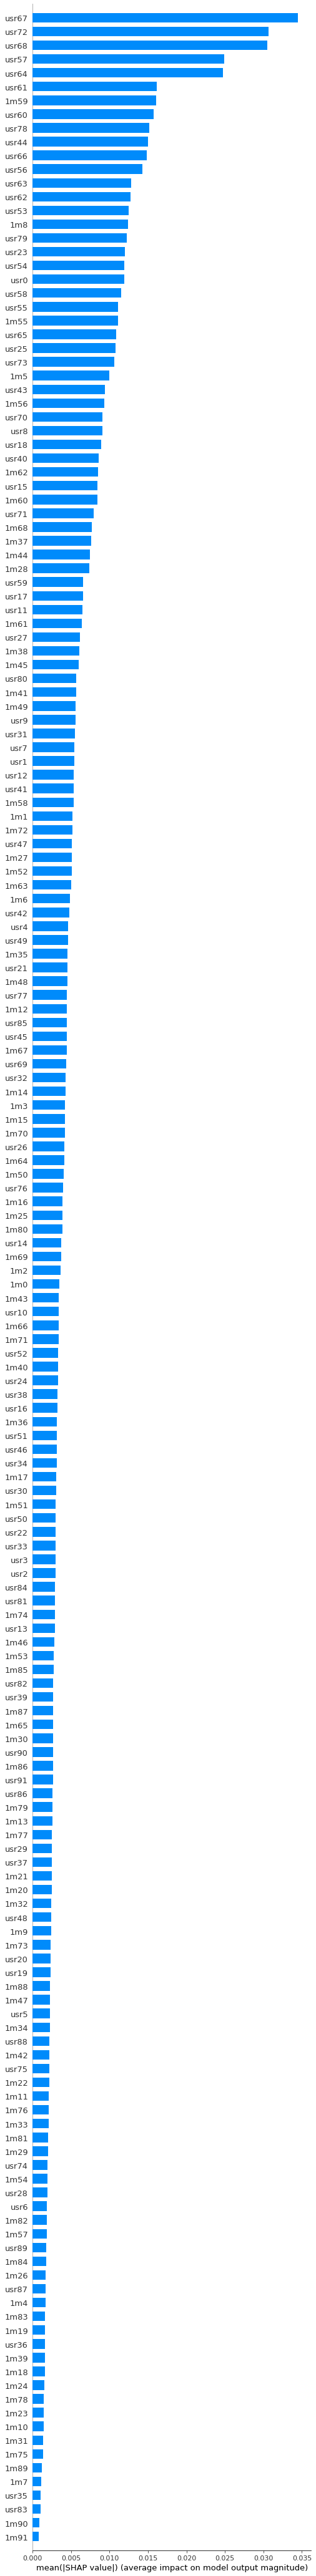

In [86]:
shap.summary_plot(shap_values, X_test_red, feature_names=labels, plot_type="bar", max_display=184, sort=True)

In [93]:
X_test_red.shape

(88, 184)

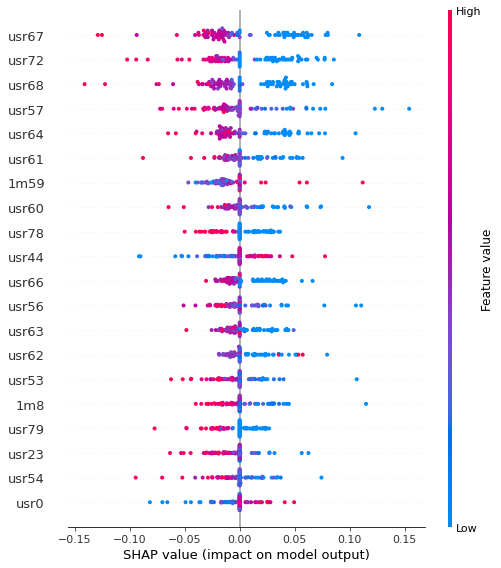

In [102]:
shap.summary_plot(shap_values, X_test_red, feature_names=labels, max_display=20)

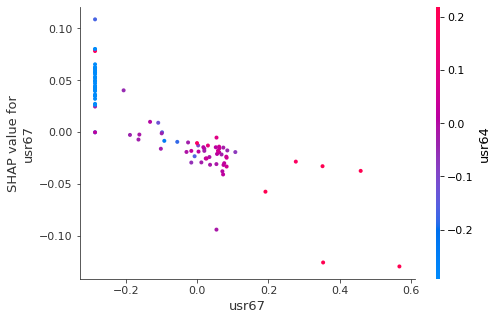

In [95]:
shap.dependence_plot("usr67", shap_values, X_test_red, feature_names=labels)

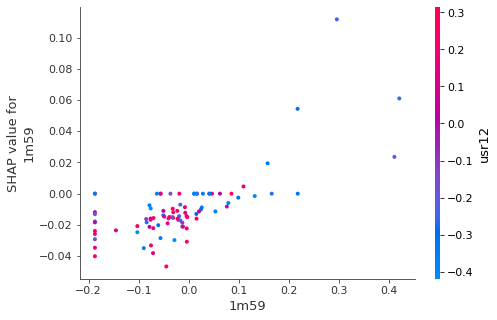

In [103]:
shap.dependence_plot("1m59", shap_values, X_test_red, feature_names=labels)

In [110]:
# X_test_red_output = X_test_red.copy()
X_test_red_output = pd.DataFrame(X_test_red, columns=labels)
X_test_red_output["pred"] = result_test
X_test_red_output.head()

,usr0,usr1,usr2,usr3,usr4,usr5,usr6,usr7,usr8,usr9,...,1m83,1m84,1m85,1m86,1m87,1m88,1m89,1m90,1m91,pred
0,0.024393,0.032745,-0.003034,-0.011215,-0.220154,-0.130764,0.084347,0.213214,-0.122566,-0.152157,...,-0.056533,-0.048451,-0.042802,-0.040200,-0.056310,-0.034836,-0.02871,-0.042958,-0.039393,1
1,-0.240835,-0.115908,-0.025974,-0.029594,0.036829,0.112812,-0.172741,-0.378697,-0.456397,-0.316157,...,-0.056533,-0.048451,-0.042802,-0.040200,-0.056310,-0.034836,-0.02871,-0.042958,-0.039393,0
2,-0.174309,-0.157538,0.001589,0.016616,0.070238,0.111032,-0.061791,-0.190944,-0.067655,0.094644,...,-0.056533,-0.048451,-0.042802,-0.040200,-0.056310,-0.034836,-0.02871,-0.042958,-0.039393,1
3,-0.096807,-0.011541,-0.089094,-0.121931,-0.071807,-0.084026,-0.256577,-0.243147,-0.420840,-0.314882,...,0.279410,0.340445,0.316735,0.258527,0.333277,0.235648,0.15095,0.245417,0.247624,0
4,-0.225091,-0.052746,-0.009279,-0.012802,0.077867,0.010209,0.011184,0.199414,0.457543,0.152354,...,-0.056533,-0.048451,-0.042802,-0.040200,-0.056310,-0.034836,-0.02871,-0.042958,-0.039393,1


In [112]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test_red[[0]], feature_names=labels)

In [114]:
shap.force_plot(explainer.expected_value, shap_values[1], X_test_red[[1]], feature_names=labels)

In [120]:
shap_v = pd.DataFrame(shap_values, columns=labels)

In [150]:
corr_list = list()
for i in range(len(shap_values)-1):
    b = np.corrcoef(shap_values[i],X_test_red[i])[1][0]
    corr_list.append(b)
corr_df = pd.concat([pd.Series(labels),pd.Series(corr_list)],axis=1).fillna(0)
# Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
corr_df.columns  = ['Variable','Corr']
corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

Text(0.5, 0, 'SHAP Value (Red = Positive Impact)')

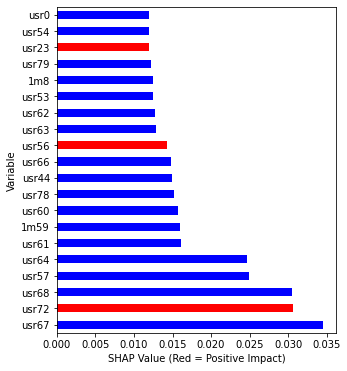

In [185]:
    # Plot it
shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_abs.mean()).reset_index()
k.columns = ['Variable','SHAP_abs']
k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
k2 = k2.sort_values(by='SHAP_abs',ascending = False)
colorlist = k2['Sign']
ax = k2.head(20).plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Red = Positive Impact)")

In [160]:
k.sort_values(by="SHAP_abs", ascending=False)

,Variable,SHAP_abs
67,usr67,0.034491
72,usr72,0.030685
68,usr68,0.030479
57,usr57,0.024896
64,usr64,0.024734
...,...,...
99,1m7,0.001114
35,usr35,0.001087
83,usr83,0.001080
182,1m90,0.000894


In [181]:
k2.tail(20)

,Variable,SHAP_abs,Corr,Sign
0,usr0,0.011884,-0.217948,blue
54,usr54,0.011910,-0.143864,blue
23,usr23,0.012010,0.025411,red
79,usr79,0.012270,-0.082190,blue
100,1m8,0.012419,0.000000,blue
53,usr53,0.012489,-0.032826,blue
62,usr62,0.012741,-0.013643,blue
63,usr63,0.012836,-0.305999,blue
56,usr56,0.014260,0.037541,red
66,usr66,0.014850,-0.345753,blue
